In [1]:
#Importando Bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as date
import tensorflow as tf


In [4]:
#Dados do Projeto

df = pd.read_csv('PETR4.SA.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5.875000,5.875000,5.875000,5.875000,1.548670,3.538944e+10
1,2000-01-04,5.550000,5.550000,5.550000,5.550000,1.462999,2.886144e+10
2,2000-01-05,5.494000,5.494000,5.494000,5.494000,1.448238,4.303360e+10
3,2000-01-06,5.475000,5.475000,5.475000,5.475000,1.443229,3.405568e+10
4,2000-01-07,5.500000,5.500000,5.500000,5.500000,1.449819,2.091264e+10
...,...,...,...,...,...,...,...
6072,2024-03-07,40.639999,40.939999,40.279999,40.389999,40.389999,5.019980e+07
6073,2024-03-08,35.900002,37.060001,35.099998,36.700001,36.700001,2.303698e+08
6074,2024-03-11,35.669998,37.740002,35.299999,35.650002,35.650002,1.275287e+08
6075,2024-03-12,36.349998,37.230000,36.160000,36.820000,36.820000,7.613910e+07


In [5]:
#Para esse projeto decidiu-se usar apenas o valor de fechamento
df = df[['Date', 'Close']]

df

,Date,Close
0,2000-01-03,5.875000
1,2000-01-04,5.550000
2,2000-01-05,5.494000
3,2000-01-06,5.475000
4,2000-01-07,5.500000
...,...,...
6072,2024-03-07,40.389999
6073,2024-03-08,36.700001
6074,2024-03-11,35.650002
6075,2024-03-12,36.820000


In [9]:
#Função de conversão da data(a data se apresenta como str e precisa ser datetime para que a rede consiga ler)

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return date.datetime(year=year, month=month, day=day)

In [10]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\badmo\AppData\Local\Temp\ipykernel_13968\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
6072   2024-03-07
6073   2024-03-08
6074   2024-03-11
6075   2024-03-12
6076   2024-03-13
Name: Date, Length: 6077, dtype: datetime64[ns]

In [11]:
#Removendo indice e utilizando data como indice

df.index = df.pop('Date')
df

,Close
Date,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2024-03-07,40.389999
2024-03-08,36.700001
2024-03-11,35.650002


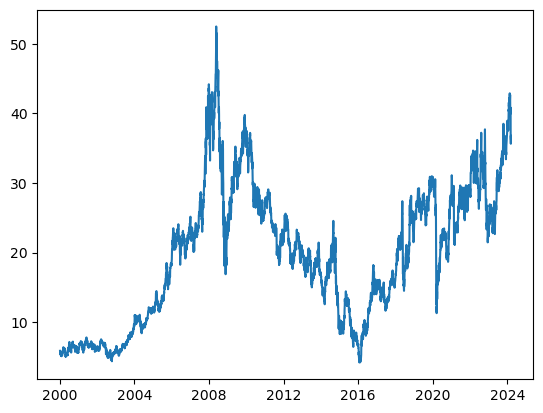

In [12]:
#Grafico dos valores de fechamento 

plt.plot(df.index, df['Close'])

In [13]:
#Função criada para target de previsão, ela vai pegar os 3 dias anteriores e vai tentar prever o valor do dia

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+date.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = date.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Primeiro dia da função 2000-01-06 
windowed_df = df_to_windowed_df(df, 
                                '2000-01-06', 
                                '2024-03-13', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2000-01-06,5.875000,5.550000,5.494000,5.475000
1,2000-01-07,5.550000,5.494000,5.475000,5.500000
2,2000-01-10,5.494000,5.475000,5.500000,5.613000
3,2000-01-11,5.475000,5.500000,5.613000,5.475000
4,2000-01-12,5.500000,5.613000,5.475000,5.483000
...,...,...,...,...,...
6069,2024-03-07,40.080002,39.959999,40.840000,40.389999
6070,2024-03-08,39.959999,40.840000,40.389999,36.700001
6071,2024-03-11,40.840000,40.389999,36.700001,35.650002
6072,2024-03-12,40.389999,36.700001,35.650002,36.820000


In [14]:
#Transformando o tipo dos dados das colunas:

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

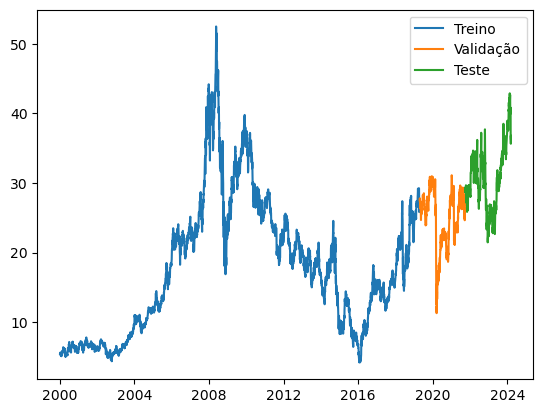

In [15]:
#Separação da base em treino 80%, validação 10% e Teste 10%

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Treino', 'Validação', 'Teste'])

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 8/100
152/152 ━━━━━━━

KeyboardInterrupt: 

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


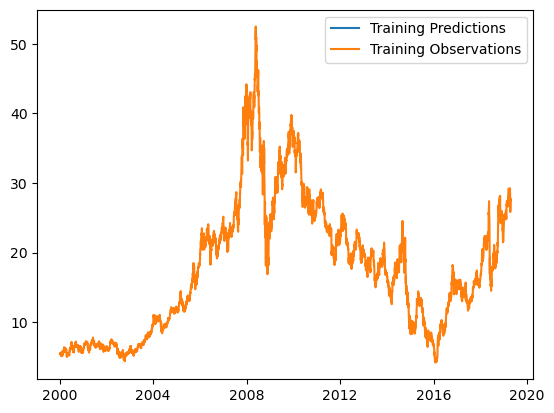

In [18]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])